In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import ardent
# from scipy.ndimage import zoom
import time
import os
import pandas as pd

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
# from proglearn.sims import generate_gaussian_parity

import pandas as pd
import SimpleITK as sitk
# from skimage.transform import rotate

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [3]:
from sklearn.datasets import make_blobs


def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    angle_params=None,
    random_state=None,
):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [4]:
def init_forest(max_depth):
    # np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    return progressive_learner, uf

In [5]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [6]:
def to_grid(test_task1, test_task2):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    new_test_task = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, new_test_task

In [7]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [8]:
def lddmm_reg(in_task_pos_reshaped, cross_task_pos_reshaped, affines, n_ite, calibrate):
#     print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    # n_ite = 50
    try:
        transform.register(target=moving, template=reference, num_iterations=n_ite, initial_affine=affines, calibrate=calibrate)
    except RuntimeError:
        try:
            transform.register(target=moving, template=reference, affine_stepsize=0.2, num_iterations=n_ite, initial_affine=affines)
        except RuntimeError:
            try:
                transform.register(target=moving, template=reference, affine_stepsize=0.1, num_iterations=n_ite, initial_affine=affines)
            except:
                return None, None, None
        except:
            return None, None, None
    except:
        return None, None, None

    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')

    deformed_reference = transform.transform_image(
        subject=reference,
        output_shape=reference.shape,
        deform_to='target'
    )
#     print("finish running lddmm")
    return deformed_moving, deformed_reference, transform

In [9]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, metric, ite):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    ParamMap = sitk.GetDefaultParameterMap('affine')
#     ParamMap['AutomaticTransformInitialization'] = ['true']
#     ParamMap['AutomaticScalesEstimation'] = ['true']
#     ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
#     ParamMap['Metric'] = [metric]
    
    ParamMap['AutomaticTransformInitialization'] = ['false']
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = [metric]
    ParamMap['MaximumNumberOfIterations'] = [ite]

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    
    return RegIm, params

In [10]:
def params_to_mat(params):
    init_affines = np.eye(3)
    init_affines[0,:2] = [float(params[0]), float(params[2])]
    init_affines[1,:2] = [float(params[1]), float(params[3])]
    init_affines[2,:2] = [float(params[4]), float(params[5])]
    return init_affines.T

In [30]:
def exp(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10):
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
    errors = np.zeros(7, dtype=float)
    
    l2f, uf = init_forest(max_depth)
    l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
    l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

    l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

    task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
    task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
    task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
    task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

    vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
    errors[1] = 1 - np.mean(
        grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
    )  # l2f task1 error

#     vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
#     errors[3] = 1 - np.mean(
#         grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
#     )  # l2f task2 error
    
    # L2F o elastix task1 error
    task1pred1_deformed, params = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '500'
    )
    vote3 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
    errors[4] = 1 - np.mean(
        grid_to_pred(vote3, test_task1, xx2, yy2) == test_label_task1
    )  
    
#     # l2f o lddmm task1 error
#     _, task1pred1_deformed_lddmm, _ = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, None, 50, False)    
#     vote4 = np.mean([task1pred1_reshaped, task1pred1_deformed_lddmm], axis=0)
#     errors[5] = 1 - np.mean(
#         grid_to_pred(vote4, test_task1, xx2, yy2) == test_label_task1
#     )  
    
    # l2f o elastix o lddmm  task1 error
#     init_affines = params_to_mat(params)
#     _, task1pred1_deformed_lddmm_sitk, _ = lddmm_reg(
#         task2pred2_reshaped, task1pred1_reshaped, init_affines, 50, False
#     )    
#     if task1pred1_deformed_lddmm_sitk is None:
#         task1pred1_deformed_lddmm_sitk = task1pred2_reshaped.copy()
#     vote5 = np.mean([task1pred1_reshaped, task1pred1_deformed_lddmm_sitk], axis=0)
#     errors[6] = 1 - np.mean(
#         grid_to_pred(vote5, test_task1, xx2, yy2) == test_label_task1
#     )  

    # UF
    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

    uf_task1 = generate_posteriors(test_task2_grid, 0, uf, [0])
    uf_task2 = generate_posteriors(test_task2_grid, 1, uf, [0])

    task1pred1_reshaped_uf = uf_task1[0][:,0].reshape(xx2.shape)
    task2pred1_reshaped_uf = uf_task2[0][:,0].reshape(xx2.shape)

    errors[0] = 1 - np.mean(
        grid_to_pred(task1pred1_reshaped_uf, test_task1, xx2, yy2) == test_label_task1
    )  # uf task1 error
#     errors[2] = 1 - np.mean(
#         grid_to_pred(task2pred1_reshaped_uf, test_task2, xx2, yy2) == test_label_task2
#     )  # uf task2 error

    return errors

In [12]:
def estimate_affines(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10):
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
    
    l2f, uf = init_forest(max_depth)
    l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
    l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

    l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

    task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
    task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
    task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
    task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)
    
    _, params = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '20'
    )
    return params_to_mat(params)

#     task1pred1_deformed, params = run_elastix(
#         task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '2000'
#     )
#     return task1pred1_deformed, params_to_mat(params), task1pred1_reshaped, task2pred2_reshaped

### estimate initial affines

In [58]:
rep = 2
angle = 45
a45 = Parallel(n_jobs=-1, verbose=1)(
    delayed(estimate_affines)(
        100, 100, ceil(log2(100)), task2_angle=np.pi*(angle/180)
    ) for _ in range(rep)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.9s finished


In [59]:
a45

[array([[ 0.951981 , -0.302874 ,  2.51061  ],
        [ 0.0612293,  0.996837 , -1.02096  ],
        [ 0.       ,  0.       ,  1.       ]]),
 array([[ 0.956162 , -0.309312 , -1.7086   ],
        [ 0.0839929,  0.952982 ,  3.22435  ],
        [ 0.       ,  0.       ,  1.       ]])]

In [60]:
np.mean(np.array(a45), axis=0)

array([[ 0.9540715, -0.306093 ,  0.401005 ],
       [ 0.0726111,  0.9749095,  1.101695 ],
       [ 0.       ,  0.       ,  1.       ]])

### compute errors

In [45]:
n_task1=100; n_task2=100; max_depth=7; n_test=1000; task1_angle=0; task2_angle=np.pi/4; n_trees=10
#source data
X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

#target data
X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
errors = np.zeros(7, dtype=float)

l2f, uf = init_forest(max_depth)
l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

l2f_task1 = generate_posteriors(test_task2_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_task2_grid, 1, l2f, [0,1])

task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
errors[1] = 1 - np.mean(
    grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
)  # l2f task1 error

# L2F o elastix task1 error
task1pred1_deformed, params = run_elastix(task1pred1_reshaped, task2pred2_reshaped, 'AdvancedNormalizedCorrelation', '500')
vote3 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
errors[4] = 1 - np.mean(
    grid_to_pred(vote3, test_task1, xx2, yy2) == test_label_task1
)  

# UF
uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

uf_task1 = generate_posteriors(test_task2_grid, 0, uf, [0])
uf_task2 = generate_posteriors(test_task2_grid, 1, uf, [0])

task1pred1_reshaped_uf = uf_task1[0][:,0].reshape(xx2.shape)
task2pred1_reshaped_uf = uf_task2[0][:,0].reshape(xx2.shape)

errors[0] = 1 - np.mean(
    grid_to_pred(task1pred1_reshaped_uf, test_task1, xx2, yy2) == test_label_task1
)  # uf task1 error

In [46]:
errors

array([0.091, 0.131, 0.   , 0.   , 0.129, 0.   , 0.   ])

In [38]:
params_to_mat(params)

array([[  0.625402,  -0.416504,   4.4609  ],
       [  0.657817,   0.811658, -12.2711  ],
       [  0.      ,   0.      ,   1.      ]])

In [47]:
# l2f o elastix o lddmm  task1 error
# init_affines = params_to_mat(params)
init_affines = np.eye(3)
init_affines[0,1] = -1; init_affines[1,0] = 1
_, task1pred1_deformed_lddmm_sitk, _ = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, init_affines, 50, False)    
if task1pred1_deformed_lddmm_sitk is None:
    task1pred1_deformed_lddmm_sitk = task1pred2_reshaped.copy()
vote5 = np.mean([task1pred1_reshaped, task1pred1_deformed_lddmm_sitk], axis=0)
errors[6] = 1 - np.mean(
    grid_to_pred(vote5, test_task1, xx2, yy2) == test_label_task1
)  
print(errors)

[0.091 0.131 0.    0.    0.129 0.    0.085]


In [50]:
_, task1pred1_deformed_lddmm_sitk_500, _ = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, init_affines, 500, False)

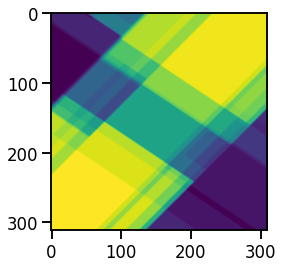

In [51]:
plt.imshow(task1pred1_deformed_lddmm_sitk_500)

In [55]:
vote4 = np.mean([task1pred1_reshaped, task1pred1_deformed_lddmm_sitk_500], axis=0)
errors[5] = 1 - np.mean(
    grid_to_pred(vote4, test_task1, xx2, yy2) == test_label_task1
)  
errors

array([0.091, 0.131, 0.   , 0.   , 0.129, 0.121, 0.085])

In [56]:
for i in [1,4,5,6]:
    print(errors[0] / errors[i])

0.694656488549618
0.705426356589147
0.7520661157024792
1.0705882352941178


Text(0.5, 1.0, 'BTE = 1.07\n (lddmm: ite=50)')

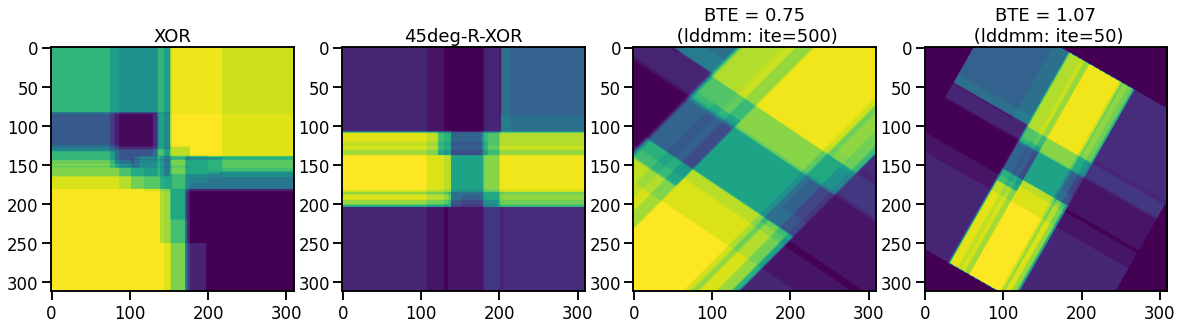

In [59]:
fig,axs = plt.subplots(1,4,figsize=(20,5))
axs[0].imshow(task1pred1_reshaped)
axs[1].imshow(task2pred2_reshaped)
axs[2].imshow(task1pred1_deformed_lddmm_sitk_500)
axs[3].imshow(task1pred1_deformed_lddmm_sitk)
axs[0].set_title('XOR')
axs[1].set_title('45deg-R-XOR')
axs[2].set_title('BTE = 0.75\n (lddmm: ite=500)')
axs[3].set_title('BTE = 1.07\n (lddmm: ite=50)')

Text(0.5, 1.0, 'elastix')

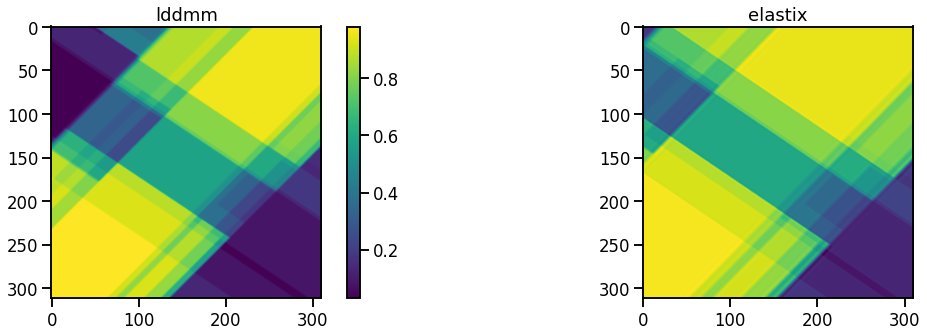

In [65]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
fig1 = axs[0].imshow(task1pred1_deformed_lddmm_sitk_500)
axs[1].imshow(task1pred1_deformed)
fig.colorbar(fig1, ax=axs[0])
axs[0].set_title('lddmm')
axs[1].set_title('elastix')

In [33]:
start_time = time.time()
print(exp(100,100,7))
print("--- %s seconds ---" % (time.time() - start_time))

[0.051 0.056 0.    0.    0.057 0.    0.   ]
--- 19.761927366256714 seconds ---


In [113]:
# start_time = time.time()
# errors_all = {}
rep = 3000
angle = 45
error45 = Parallel(n_jobs=-1, verbose=1)(
    delayed(exp)(
        100, 100, ceil(log2(100)), task2_angle=np.pi*(angle/180)
    ) for _ in range(rep)
)

# print("--- %s seconds ---" % (time.time() - start_time))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 105.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 165.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 238.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 323.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 398.2min finished


In [117]:
for i in [1,6]:
    print(np.mean(np.array(error45)[:2000,0]) / np.mean(np.array(error45)[:2000,i]))

0.8896756024336461
0.8920456059031941


In [43]:
errors_all = {}
errors_all["error45"] = error45

In [44]:
pickle_out = open("errors_all-sitk-lddmm-angles0_15_90-n_samples100.pickle", "wb")
pickle.dump(errors_all, pickle_out)
pickle_out.close()

In [45]:
pickle_in = open("errors_all-sitk-lddmm-angles0_15_90-n_samples100.pickle", "rb")
i = pickle.load(pickle_in)

In [24]:
errors1

[array([0.056, 0.065, 0.   , 0.   , 0.1  , 0.066, 0.071]),
 array([0.054, 0.067, 0.   , 0.   , 0.064, 0.061, 0.058]),
 array([0.065, 0.094, 0.   , 0.   , 0.093, 0.066, 0.06 ]),
 array([0.086, 0.074, 0.   , 0.   , 0.066, 0.667, 0.064]),
 array([0.111, 0.105, 0.   , 0.   , 0.105, 0.116, 0.111]),
 array([0.051, 0.079, 0.   , 0.   , 0.074, 0.639, 0.055]),
 array([0.059, 0.044, 0.   , 0.   , 0.067, 0.046, 0.039]),
 array([0.046, 0.049, 0.   , 0.   , 0.054, 0.404, 0.054]),
 array([0.066, 0.069, 0.   , 0.   , 0.073, 0.063, 0.065]),
 array([0.054, 0.083, 0.   , 0.   , 0.08 , 0.35 , 0.062]),
 array([0.058, 0.107, 0.   , 0.   , 0.064, 0.635, 0.064]),
 array([0.053, 0.052, 0.   , 0.   , 0.086, 0.074, 0.05 ]),
 array([0.065, 0.064, 0.   , 0.   , 0.106, 0.079, 0.063]),
 array([0.061, 0.066, 0.   , 0.   , 0.079, 0.645, 0.065]),
 array([0.046, 0.052, 0.   , 0.   , 0.077, 0.068, 0.065]),
 array([0.067, 0.075, 0.   , 0.   , 0.071, 0.068, 0.069])]

In [27]:
for i in [1,4,5,6]:
    print(np.mean(np.array(errors1)[:,0]) / np.mean(np.array(errors1)[:,i]))

0.871615720524018
0.792692613185068
0.24660242154682488
0.9832512315270939
